In [2]:
import numpy as np
import synth.covariance
from dolphin.phase_link import simulate, covariance
from jax import jit, vmap, jacobian
import jax.numpy as jnp
import matplotlib.pyplot as plt

# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext rich


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rich extension is already loaded. To reload it, use:
  %reload_ext rich


In [3]:
@jit
def phase_link(c_hat):
    eigs, vecs = jnp.linalg.eigh(c_hat)
    vec = vecs[:, -1]
    return jnp.angle(vec * vec[0].conj())



In [21]:

num_dates = 10
gamma_inf_clean = 0.8
gamma_inf_noisy = 0.0

C_clean, truth_clean = simulate.simulate_coh(num_dates, gamma_inf=gamma_inf_clean)
C_noisy, truth_noisy = simulate.simulate_coh(num_dates, gamma_inf=gamma_inf_noisy)
samples_clean = simulate.simulate_neighborhood_stack(C_clean)
samples_noisy = simulate.simulate_neighborhood_stack(C_noisy)
C_hat_clean = covariance.coh_mat_single(samples_clean)
C_hat_noisy = covariance.coh_mat_single(samples_noisy)


In [5]:
print(phase_link(C_clean))
print(phase_link(C_hat_clean))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.          0.01813199  0.01611498 -0.00144899 -0.0133987  -0.00541469
 -0.01327175 -0.03096185 -0.00806082 -0.01003637 -0.00051688 -0.0124838
 -0.03389647 -0.03189792 -0.00522084 -0.04020542 -0.01885547 -0.0409277
 -0.04070852 -0.06248346]


In [6]:
print(phase_link(C_noisy))
print(phase_link(C_hat_noisy))


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.0460258  0.11820398 0.1389474  0.18367223 0.11762726
 0.11843891 0.12073592 0.0891486  0.09071026 0.14760867 0.16135909
 0.17260873 0.156296   0.17454621 0.201862   0.21475962 0.23261498
 0.26058212 0.19988862]


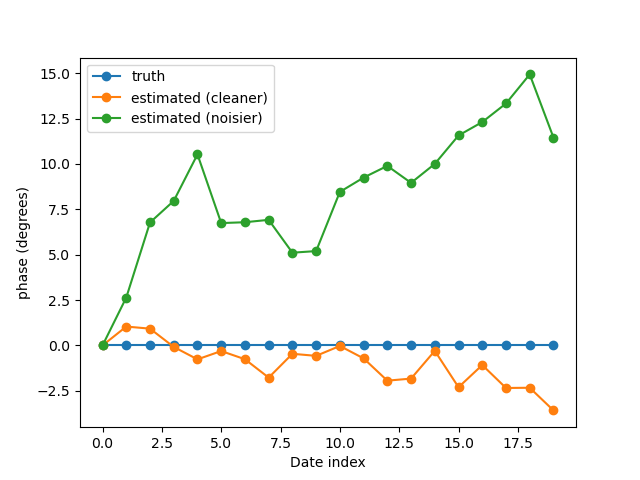

In [7]:
fig, ax = plt.subplots(1, 1)

# plot the estimated phase vs truth
ax.plot(np.degrees(phase_link(C_clean)), "-o", label="truth")
ax.plot(np.degrees(phase_link(C_hat_clean)), "-o", label="estimated (cleaner)")
ax.plot(np.degrees(phase_link(C_hat_noisy)), "-o", label="estimated (noisier)")

ax.set_ylabel("phase (degrees)")
ax.set_xlabel("Date index")
ax.legend()

## Getting the Jacobian of the phase linking function

In [8]:
# Use JAX autodiff to get the jacobian of our function
# https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html

J_phase_link = jacobian(phase_link)

# Call the jacobian function for the covariance matrixes

J_clean = J_phase_link(C_hat_clean)
J_noisy = J_phase_link(C_hat_noisy)

print(J_clean.shape)

(20, 20, 20)


### Interpreting the shape of the jacobian output

The input of `phase_link` is the 20 x 20 estimated (complex) covariance matrix.
The output is the (real) phase vector of length 20.

In general, the Jacobian $J_f$ of a function $f$ is a matrix of partial derivatives, which maps small changes in the input to small changes in the output.
For an infinitesimal change in the input $dx$, the linear portion of the change in the output is
$$
dy = J_f dx
$$

If instead we use small perturbations $\delta x$ instead of infinitesimal changes (representing the uncertainty in the input), then the propagation of uncertainty is
$$
\Sigma_{y y} = J_f \Sigma_{x x} J_f^T
$$

The shapes should be
- $J_f$: (20, 20, 20)


In [9]:
@jit
def phase_link_smaller(c_hat):
    eigs, vecs = jnp.linalg.eigh(c_hat)
    vec = vecs[:, -1]
    return jnp.angle(vec * vec[0].conj())[:3]



In [10]:
print(phase_link_smaller(C_hat_clean))
J_phase_link_smaller = jacobian(phase_link_smaller)
print(J_phase_link_smaller(C_hat_clean).shape)
print((J_phase_link_smaller(C_hat_clean) @ C_hat_clean).shape)

[0.         0.01813199 0.01611498]
(3, 20, 20)
(3, 20, 20)


In [11]:
print(C_hat_clean.ravel().shape)
print(J_clean.reshape(20, -1).shape)
(J_clean.reshape(20, -1) @ C_hat_clean.reshape(-1, 1)).shape

(400,)
(20, 400)


(20, 1)

In [12]:
# sigma_yy = (J_clean.reshape(20, -1) @ C_hat_clean.reshape(-1, 1) ravel()) @ J_clean.reshape(20, -1).T

In [13]:
print(np.abs(J_phase_link(C_hat_noisy).reshape(20, -1)))

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00065857 0.11610762 0.07575575 ... 0.00056109 0.00058215 0.00066155]
 [0.00064705 0.06642965 0.1212964  ... 0.00100535 0.00118228 0.00130827]
 ...
 [0.00066796 0.06622975 0.07746588 ... 0.05045539 0.00145059 0.00130454]
 [0.0012327  0.06629279 0.07764317 ... 0.00159169 0.05381839 0.00120437]
 [0.00163451 0.06623726 0.07762346 ... 0.0669243  0.06115823 0.00163433]]


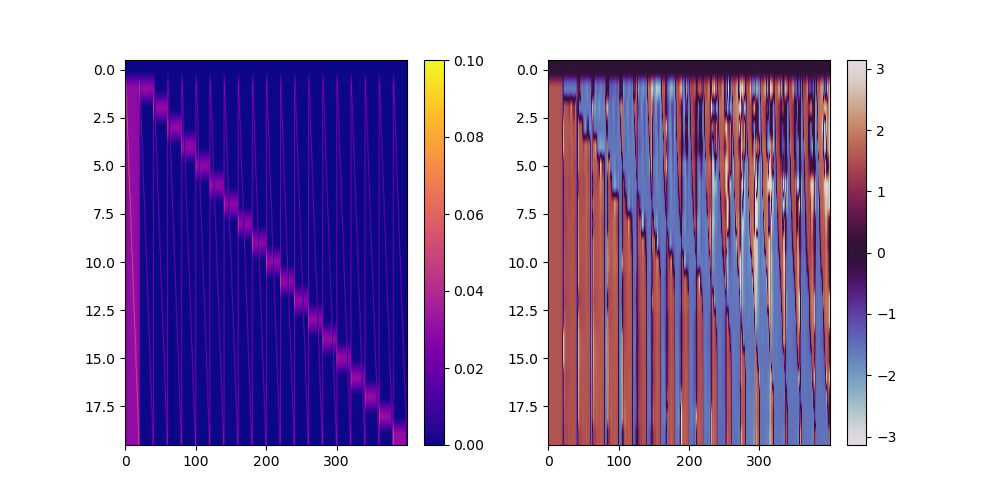

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axim = axes[0].imshow(np.abs(J_phase_link(C_hat_clean).reshape(20, -1)), cmap='plasma', vmax=0.1)
fig.colorbar(axim, ax=axes[0])
axes[0].set_aspect("auto")

axim = axes[1].imshow(np.angle(J_phase_link(C_hat_clean).reshape(20, -1)), cmap='twilight')
fig.colorbar(axim, ax=axes[1])
axes[1].set_aspect("auto")

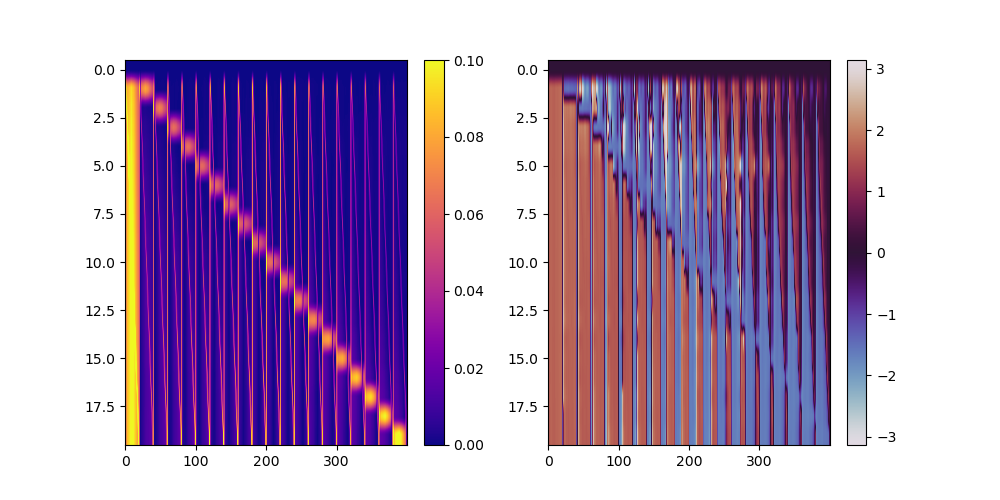

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axim = axes[0].imshow(np.abs(J_phase_link(C_hat_noisy).reshape(20, -1)), cmap='plasma', vmax=0.1)
fig.colorbar(axim, ax=axes[0])
axes[0].set_aspect("auto")

axim = axes[1].imshow(np.angle(J_phase_link(C_hat_noisy).reshape(20, -1)), cmap='twilight')
fig.colorbar(axim, ax=axes[1])
axes[1].set_aspect("auto")

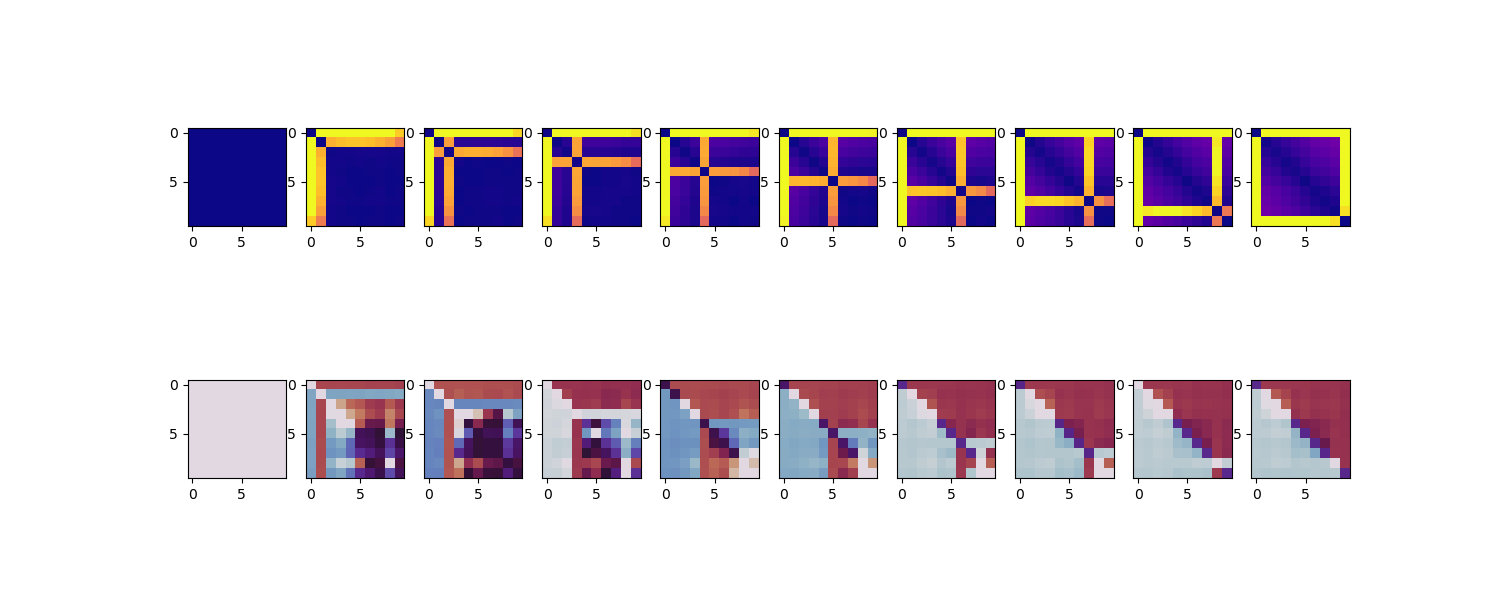

In [ ]:
fig, axes = plt.subplots(2, num_dates, figsize=(15, 6))
for i in range(num_dates):

    axes[0, i].imshow(np.abs(J_phase_link(C_hat_noisy))[i], cmap='plasma', vmax=0.1)
    axes[1, i].imshow(np.angle(J_phase_link(C_hat_noisy))[i], cmap='twilight')

# axes[0].set_aspect("auto")


In [35]:
@jit
def phase_link_full(samples):
    c_hat = covariance.coh_mat_single(samples)
    eigs, vecs = jnp.linalg.eigh(c_hat)
    vec = vecs[:, -1]
    return jnp.angle(vec * vec[0].conj())

@jit
def phase_link_smaller_full(samples):
    c_hat = covariance.coh_mat_single(samples)
    eigs, vecs = jnp.linalg.eigh(c_hat)
    vec = vecs[:, -1]
    return jnp.angle(vec * vec[0].conj())[:3]



In [36]:
J_phase_link_full = jacobian(phase_link_full)
J_phase_link_smaller_full = jacobian(phase_link_smaller_full)

In [30]:
J_phase_link_smaller_full(samples_clean).shape

(3, 10, 200)

In [34]:
np.round(J_phase_link_smaller_full(samples_clean).reshape(3, -1) @ J_phase_link_smaller_full(samples_clean).reshape(3, -1).T.conj(), 3)


Array([[0.   +0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.012+0.j, 0.006-0.j],
       [0.   +0.j, 0.006+0.j, 0.012+0.j]], dtype=complex64)

In [37]:
np.round(J_phase_link_full(samples_clean).reshape(num_dates, -1) @ J_phase_link_full(samples_clean).reshape(num_dates, -1).T.conj(), 3)


Array([[0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j,
        0.   +0.j, 0.   +0.j, 0.   +0.j, 0.   +0.j],
       [0.   +0.j, 0.012+0.j, 0.006-0.j, 0.006+0.j, 0.006+0.j, 0.006+0.j,
        0.006+0.j, 0.006+0.j, 0.006+0.j, 0.006-0.j],
       [0.   +0.j, 0.006+0.j, 0.012+0.j, 0.006+0.j, 0.006+0.j, 0.006+0.j,
        0.006+0.j, 0.006-0.j, 0.006+0.j, 0.006-0.j],
       [0.   +0.j, 0.006-0.j, 0.006-0.j, 0.012+0.j, 0.006+0.j, 0.006-0.j,
        0.006-0.j, 0.006-0.j, 0.006-0.j, 0.006-0.j],
       [0.   +0.j, 0.006-0.j, 0.006-0.j, 0.006-0.j, 0.012+0.j, 0.006-0.j,
        0.006-0.j, 0.006-0.j, 0.006-0.j, 0.006-0.j],
       [0.   +0.j, 0.006-0.j, 0.006-0.j, 0.006+0.j, 0.006+0.j, 0.012+0.j,
        0.006-0.j, 0.006-0.j, 0.006-0.j, 0.006-0.j],
       [0.   +0.j, 0.006-0.j, 0.006-0.j, 0.006+0.j, 0.006+0.j, 0.006+0.j,
        0.012+0.j, 0.006-0.j, 0.006-0.j, 0.006-0.j],
       [0.   +0.j, 0.006-0.j, 0.006+0.j, 0.006+0.j, 0.006+0.j, 0.006+0.j,
        0.006+0.j, 0.012+0.j, 0.006-

In [51]:
def get_out_cov(samples):
    out = J_phase_link_full(samples).reshape(num_dates, -1) @ J_phase_link_full(samples).reshape(num_dates, -1).T.conj()
    return out.real
    

In [52]:
cyy_clean = get_out_cov(samples_clean)
cyy_noisy = get_out_cov(samples_noisy)

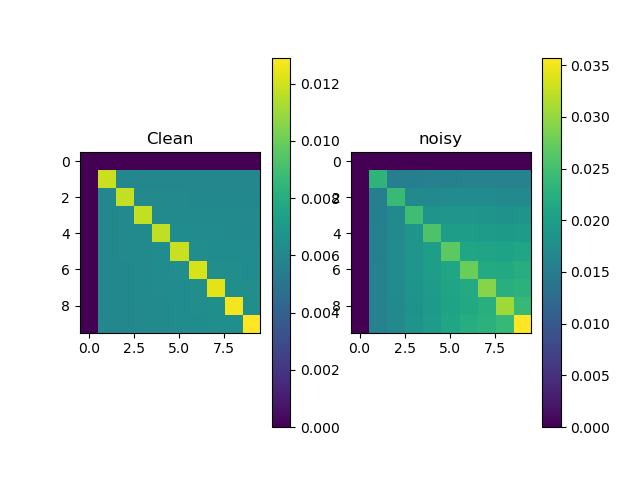

In [54]:
fig, axes = plt.subplots(1, 2)
# plt.figure()
# plt.imshow(cyy_clean)
# plt.colorbar()

axim = axes[0].imshow(cyy_clean)
axes[0].set_title('Clean')
fig.colorbar(axim, ax=axes[0])
axim = axes[1].imshow(cyy_noisy)
axes[1].set_title('noisy')
fig.colorbar(axim, ax=axes[1])

In [58]:
import numpy as np
from numpy.typing import ArrayLike
# import jax.numpy as np  # uncomment to use JAX

def compute_crlb(coherence_matrix: ArrayLike, num_looks: int) -> np.ndarray:
    """Compute the Cramer-Rao Lower Bound (CRLB) for phase linking estimation.
    
    Parameters
    ----------
    coherence_matrix : ArrayLike
        Complex (true) coherence matrix (N x N)

    num_looks : int
        Number of looks used in estimation

    
    Returns
    -------
    crlb : np.ndarray
        Covariance matrix (N-1 x N-1) representing the CRLB

    """
    N = coherence_matrix.shape[0]
    
    # Create basis matrix B to handle rank deficiency
    # This maps N phases to N-1 phase differences
    B = np.zeros((N, N-1))
    B[1:, :] = np.eye(N-1)
    
    # Compute inverse of absolute coherence matrix
    abs_coherence = np.abs(coherence_matrix)
    L = np.linalg.cholesky(abs_coherence)
    inv_abs_coherence = np.linalg.inv(L @ L.T)
    
    # Compute Fisher Information Matrix
    # FIM_ij = 2L|γ_ij|²/(1-|γ_ij|²)
    X = 2 * num_looks * (abs_coherence * inv_abs_coherence - np.eye(N))
    
    # Project FIM to N-1 space and invert to get covariance
    projected_fim = B.T @ (X + np.eye(N)) @ B
    crlb = np.linalg.inv(projected_fim)
    
    # Ensure symmetry (handle numerical issues)
    return (crlb + crlb.T) / 2


# crlb = compute_crlb(example_coherence, num_looks=20)
# print("CRLB matrix shape:", crlb.shape)  # Should be (2, 2) for 3 acquisitions
# print("CRLB diagonal elements:", np.diag(crlb))  # Variance bounds

In [61]:
print(np.diag(compute_crlb(C_hat_clean, num_looks=samples_clean.shape[1])))

[0.00016281 0.00032172 0.00043921 0.00058471 0.00068524 0.00074403
 0.00082025 0.00089868 0.00091276]


In [70]:
crlb_clean = compute_crlb(C_hat_clean, num_looks=samples_clean.shape[1])
crlb_noisy = compute_crlb(C_hat_noisy, num_looks=samples_noisy.shape[1])
crlb_std_clean_deg = np.concatenate([[0], np.degrees(np.sqrt(np.diag(crlb_clean)))])
crlb_std_noisy_deg = np.concatenate([[0], np.degrees(np.sqrt(np.diag(crlb_noisy)))])

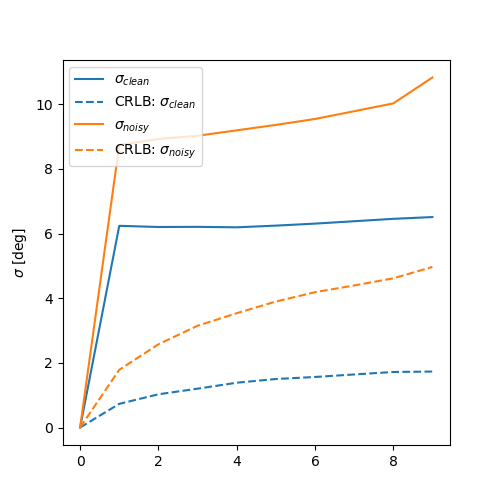

In [71]:
# plot the diagonal, standard deviation, as degrees
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(np.degrees(np.sqrt(np.diag(cyy_clean))), label=r"$\sigma_{clean}$", color="C0")
ax.plot(crlb_std_clean_deg, label=r"CRLB: $\sigma_{clean}$", color="C0", linestyle="--")

ax.plot(np.degrees(np.sqrt(np.diag(cyy_noisy))), label=r"$\sigma_{noisy}$", color="C1")
ax.plot(crlb_std_noisy_deg, label=r"CRLB: $\sigma_{noisy}$", color="C1", linestyle="--")
ax.set_ylabel(r"$\sigma$ [deg]")

ax.legend()